In [3]:
import matplotlib as plt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import math
import scipy.stats as stats

In [4]:


# Naloži podatke
df = pd.read_csv('Hobotnice.csv')

stolpec = df.columns[0]

# Izračun povprečja in standardnega odklona
povprecje = df[stolpec].mean()
std_odklon = df[stolpec].std()  # privzeto ddof=1 = vzorčni odklon

# Izpis rezultatov
print(f"Povprečje: {povprecje:.4f}")
print(f"Standardni odklon: {std_odklon:.4f}")

Povprečje: 43.9677
Standardni odklon: 35.6045


Širine razredov $w$ določimo po modificiranem Freedman-Diaconisovemu pravilu:

$$w \doteq \frac{2.6  \cdot \mathrm{IQR}}{\sqrt[3]{n}}$$


In [5]:
#Poračunamo IQR:

df = pd.read_csv('Hobotnice.csv', header=None)

# Izberi stolpec
stolpec = df.columns[0]

# Izračun IQR
q1_min = df[stolpec].quantile(0.25, interpolation = 'lower') # minimum prvega kvartila
q3_max = df[stolpec].quantile(0.75, interpolation = 'higher') # maksimum tretjega kvartila
iqr = q3_max - q1_min

# Izpis
print(f"IQR: {iqr:.4f}")


IQR: 41.0000


In [6]:
#Približne širine razredov bodo torej:
n = 94
sirina = 2.6*iqr/np.cbrt(n)

print(sirina)

23.444874923607667


Širino, dobljeno po Freedman-Diaconisu zaokrožimo na 20 ("najbližji večkratnik števila 10") in to upoštevamo pri risanju histograma

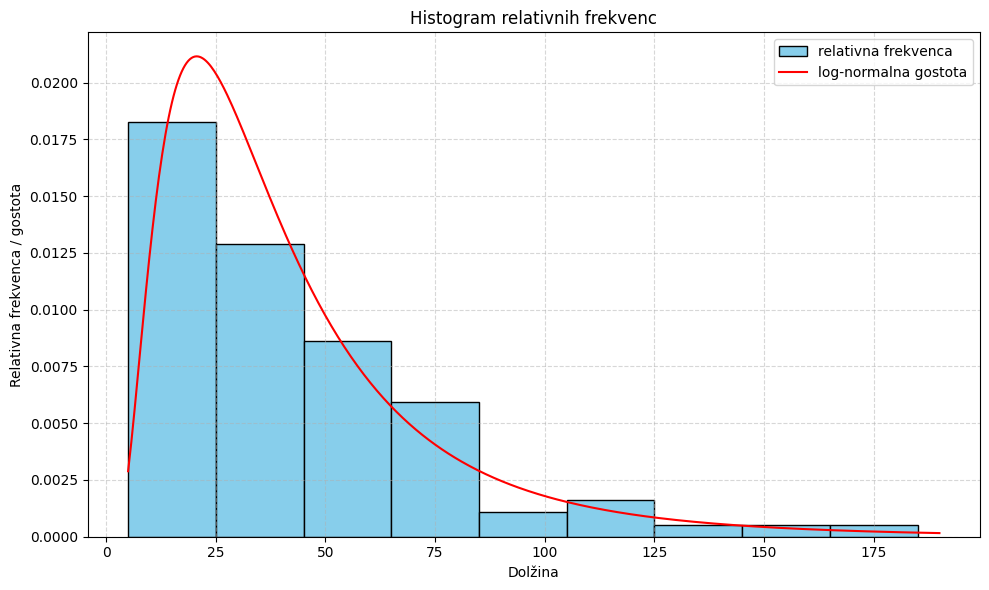

In [7]:
from scipy.stats import lognorm

df = pd.read_csv('Hobotnice.csv', header=None)

# Histogram - določimo širino stolpca
sirina = 20
min_vrednost = df[stolpec].min()
max_vrednost = df[stolpec].max()
meje = np.arange(min_vrednost, max_vrednost, sirina)

# Histogram relativnih frekvenc
plt.figure(figsize=(10, 6))
plt.hist(df[stolpec], bins=meje, color='skyblue', edgecolor='black', density=True, label='relativna frekvenca')

# Log-normalna gostota
povp = 43.9677
std = 35.6045

# Pretvori v parametre log-normalne porazdelitve
# iz aritmetičnega povprečja in odklona
varianca = std**2
phi = np.sqrt(np.log(1 + varianca / povp**2))        # sigma (parametrizacija lognorm)
mu = np.log(povp) - 0.5 * phi**2                      # mu (log-povp)

# x-vrednosti za gostoto
x = np.linspace(min_vrednost, max_vrednost, 500)
pdf = lognorm.pdf(x, s=phi, scale=np.exp(mu))

# Nariši gostoto
plt.plot(x, pdf, 'r-', label='log-normalna gostota')
plt.title('Histogram relativnih frekvenc')
plt.xlabel('Dolžina')
plt.ylabel('Relativna frekvenca / gostota')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()

plt.show()

In [8]:
#Da določimo širine stolpcev, moramo poračunati še IQR logaritmov

# Odstrani vrednosti ≤ 0 (log ni definiran)
podatki = df[df[stolpec] > 0][stolpec]

# Izračun logaritmov (naravni logaritem)
log_podatki = np.log(podatki)

# Izračun IQR logaritmov
q1 = np.quantile(log_podatki, 0.25, method = 'lower') # Vzamemo najmanjšo vrednost za prvi kvartil
q3 = np.quantile(log_podatki, 0.75, method = 'higher') # Vzamemo navečjo vrednost za tretji kvartil
iqr_log = q3 - q1

# Izpis rezultatov
print(f"Q1 (log): {q1:.4f}")
print(f"Q3 (log): {q3:.4f}")
print(f"IQR logaritmov: {iqr_log:.4f}")

Q1 (log): 2.9444
Q3 (log): 4.0943
IQR logaritmov: 1.1499


In [9]:
#Poračunamo širine razredov po modificiranem Freedman-Diaconisovem pravilu:
n = len(log_podatki)
sirina_log = 2.6 * iqr_log / np.cbrt(n)
print(sirina_log)

0.6575461602121487


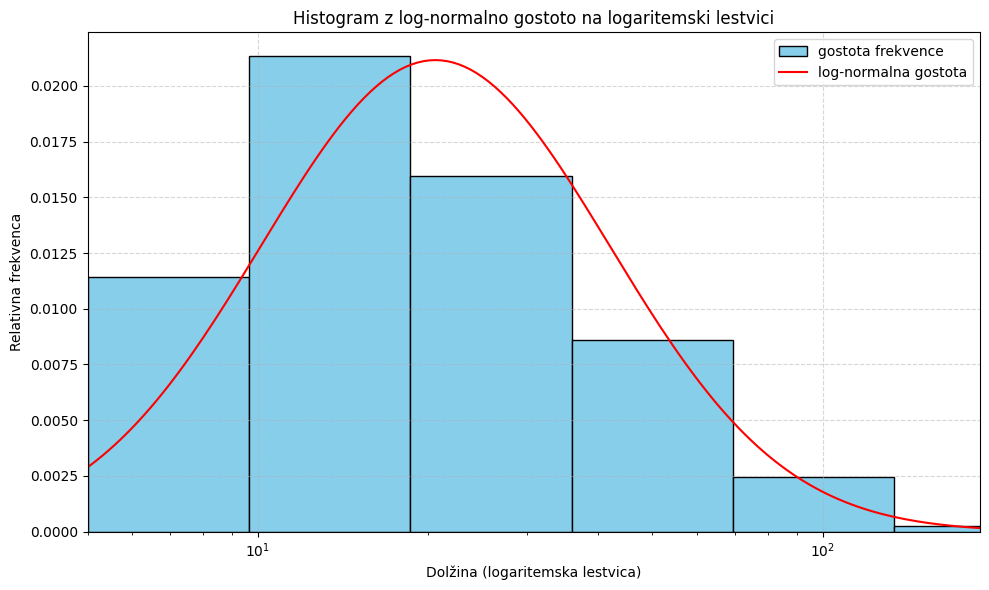

In [10]:
#Najprej podatke logaritmiramo in enako široke razrede določimo na logaritmiranih podatkih.
#To omogoča, da bodo navidezne širine enake na logaritemski lestvici.
#Nato meje razredov eksponenciramo, da dobimo meje v originalni lestvici.
# Določimo robove razredov na log-lestvici
min_log = log_podatki.min()
max_log = log_podatki.max()
meje_log = np.arange(min_log, max_log + sirina_log, sirina_log)
razredi = np.exp(meje_log)  # pretvori nazaj v originalno lestvico, zato da bodo "enake" širine na logaritemski lestvici

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(podatki, bins=razredi, color='skyblue', edgecolor='black', density=True, label='gostota frekvence')

# Log-normalna gostota
x = np.logspace(0, np.log(podatki.max()), 500)
pdf = lognorm.pdf(x, s=phi, scale=np.exp(mu))
plt.plot(x, pdf, 'r-', label='log-normalna gostota')

plt.xscale('log')
plt.xlim(podatki.min(), podatki.max())
plt.xlabel('Dolžina (logaritemska lestvica)')
plt.ylabel('Relativna frekvenca')
plt.title('Histogram z log-normalno gostoto na logaritemski lestvici')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

OPOMBA!
Q-Q grafikone naredimo zgolj iz točk, kakor v Riceu

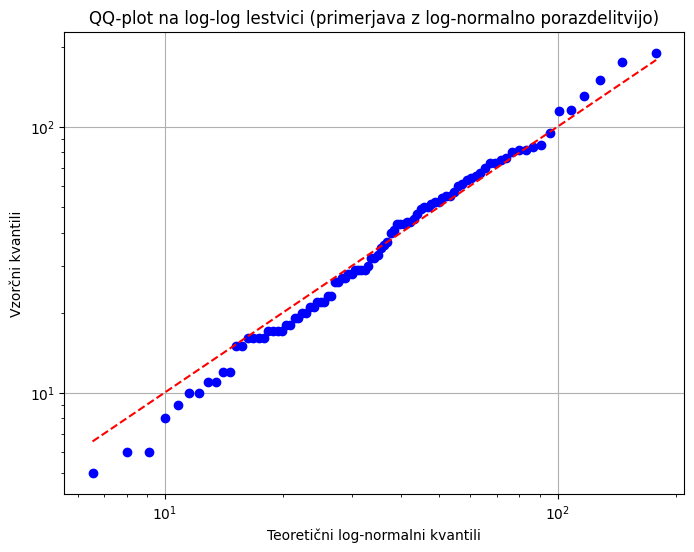

In [11]:
podatki = pd.read_csv('Hobotnice.csv')

# Pretvorimo v 1D array (94 vrednosti)
vzorec = podatki.values.ravel()

# Generiramo teoretične kvantile
teoreticni_kvantili = stats.lognorm.ppf(
    np.linspace(0.01, 0.99, len(vzorec)), s=phi, scale=np.exp(mu))

# Narišemo na log-log skali
plt.figure(figsize=(8, 6))
plt.loglog(teoreticni_kvantili, np.sort(vzorec), 'bo')  # Log-log QQ-plot
plt.loglog(teoreticni_kvantili, teoreticni_kvantili, 'r--')  # Referenčna črta


plt.xlabel("Teoretični log-normalni kvantili")
plt.ylabel("Vzorčni kvantili")
plt.title("QQ-plot na log-log lestvici (primerjava z log-normalno porazdelitvijo)")
plt.grid(True)
plt.show()
